In [1]:
import sys, os
from pathlib import Path
sys.path.append(os.path.abspath(Path().resolve().parent/'src'))


from kinematicsrobotics.model import Cluster
from kinematicsrobotics.datahandler import Save, Extract

In [47]:
ext = Extract()
ext._path_project = os.path.abspath(Path().resolve().parent)
#dataset = ext.dataframe(r'src\data\raw\dataset-semi-raw.csv')
dataset = ext.dataframe(r'src\data\ready\dataset-radius-1cm.csv')
dataset.shape

(6889, 11)

In [48]:
kmeans = Cluster(data = dataset[['p_x','p_y','p_z']], 
                n_clusters = 4, 
                n_init = 'auto'
)

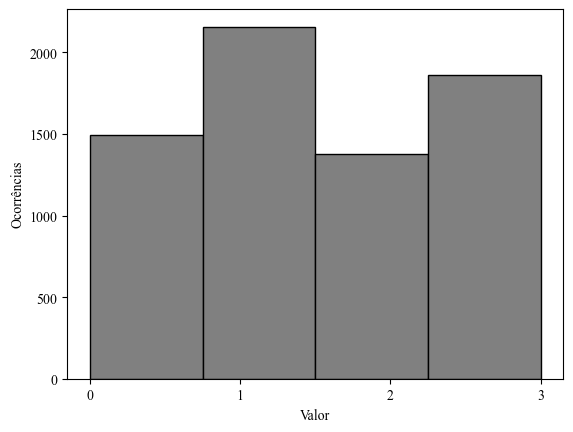

In [49]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.rcParams["font.family"] = "Times New Roman"
plt.hist(kmeans._model.labels_, bins=4, color='gray', edgecolor='black')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# Adicionar título e rótulos

plt.xlabel("Valor")
plt.ylabel("Ocorrências")

# Exibir o gráfico
plt.show()


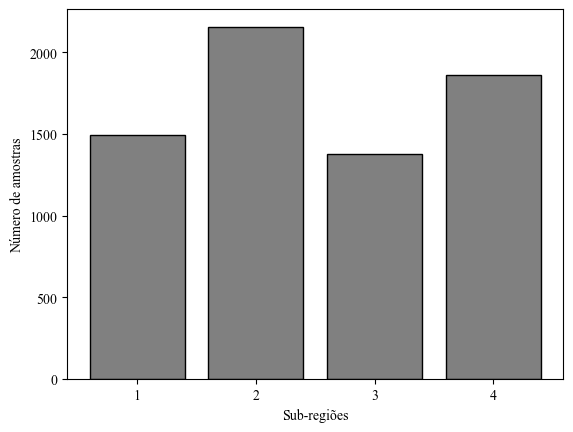

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# Definir estilo da fonte
plt.rcParams["font.family"] = "Times New Roman"

# Contar a frequência de cada cluster
clusters, counts = np.unique(kmeans._model.labels_, return_counts=True)

# Criar gráfico de barras
plt.bar(clusters+1, counts, color='gray', edgecolor='black')

# # Adicionar título e rótulos
# plt.title('Distribuição dos Clusters', fontsize=14)
plt.xlabel('Sub-regiões')
plt.ylabel('Número de amostras')

# Forçar o eixo x a ser inteiro
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Exibir o gráfico
plt.show()

In [7]:
from kinematicsrobotics.model import Model
from kinematicsrobotics.model import Cluster
from kinematicsrobotics.datahandler import Save, Extract
from kinematicsrobotics.dataprocessing import Preprocessing

class LocalModel:
    def __init__(self, *, model_cluster: Cluster, data, **kw):
        self._model_cluster = model_cluster
        self.models(**kw)
        self.clusters(data = data)
    
    
    def models(self, **kw):
        models = []
        for k in self._model_cluster._class_cluster:
            models.append(Model.mlp_regressor(**kw))
        
        self._models = models
    
    def set_model(self,**params):
        for model in self._models:
            model.set_model(**params)

    def fit(self):
        i = 0
        for model in self._models:
            x_train, x_test, y_train, y_test = self._data_processing[i].data_train_test
            model.fit(x = x_train, y = y_train)
            i +=1

    def clusters(self, data):
        clusteres = set(self._model_cluster._model.labels_)
        data_clusters = []
        for cluster in clusteres:
            idex_labes = []
            i = 0
            for labels in self._model_cluster._model.labels_:
                if labels == cluster:
                    idex_labes.append(i)
                i +=1
            data_clusters.append(data.iloc[idex_labes])

        self._data_clusters = data_clusters


    def split(self, *, test_size = 0.1):
        data_processing = []
        for cluster in self._data_clusters:
            data_processing.append(Preprocessing(dataset = cluster, 
                                    x_labels=['p_x', 'p_y','p_z', 'roll', 'pich', 'yaw'],
                                    y_labels=['theta_1', 'theta_2', 'theta_3', 'theta_4'], 
                                    size_test = test_size
                                    )
            )
        self._data_processing = data_processing
            

    # def predict(self,*, x):
    #     return self._model.predict(x)

In [8]:
mlps = LocalModel(model_cluster=kmeans,
                  data = dataset,
                  early_stopping=True, 
                  EPOCHS=1000, 
                  EPOCHS_NOCHANGE=30,
                  random_state=42, 
                  verbose=True,
                  hidden_layer_sizes = (320, 375, 265, 155),
                  activation = 'relu'
                  )

In [9]:
mlps.split(test_size=0.1)

In [10]:
mlps.fit()

Iteration 1, loss = 0.36136358
Validation score: 0.637126
Iteration 2, loss = 0.15125133
Validation score: 0.819128
Iteration 3, loss = 0.06959971
Validation score: 0.920443
Iteration 4, loss = 0.03850144
Validation score: 0.938503
Iteration 5, loss = 0.02508831
Validation score: 0.956842
Iteration 6, loss = 0.01695278
Validation score: 0.970349
Iteration 7, loss = 0.01272951
Validation score: 0.970801
Iteration 8, loss = 0.01015343
Validation score: 0.975657
Iteration 9, loss = 0.00763235
Validation score: 0.978141
Iteration 10, loss = 0.00649644
Validation score: 0.981953
Iteration 11, loss = 0.00609546
Validation score: 0.980821
Iteration 12, loss = 0.00646134
Validation score: 0.982855
Iteration 13, loss = 0.00533687
Validation score: 0.984109
Iteration 14, loss = 0.00458394
Validation score: 0.986560
Iteration 15, loss = 0.00408944
Validation score: 0.985833
Iteration 16, loss = 0.00364043
Validation score: 0.983700
Iteration 17, loss = 0.00326387
Validation score: 0.984633
Iterat

In [33]:
for model in mlps._models:
    loss=model._model.loss_

loss/4

0.00018583438915207142

In [34]:
a = 0.0021319917287944026+0.000665576399602167+0.000977069887152703+0.00034571466991975406
a/4

0.0010300881713672567

Text(0, 0.5, 'MSE')

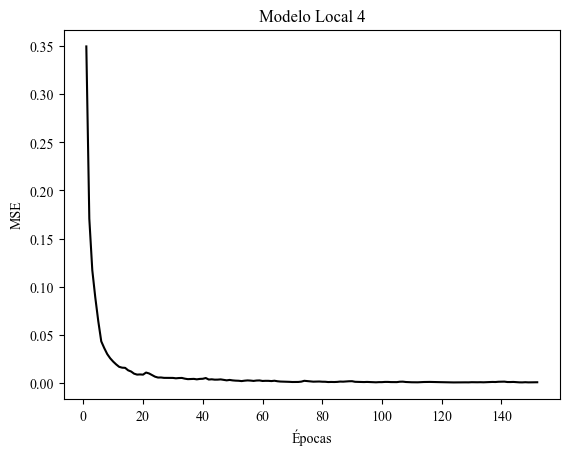

In [16]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

n = 4
loss = mlps._models[n-1]._model.loss_curve_

plt.plot(range(1,len(loss)+1), loss, color='black')
plt.title(f"Modelo Local {n}")
plt.xlabel("Épocas")
plt.ylabel("MSE")



### Métricas

In [17]:
from pandas import DataFrame

In [18]:
from kinematicsrobotics.kinematics import Robo
from kinematicsrobotics.metrics import Metrics
Elos = [['theta_1',10,0,90,0],
        ['theta_2',0,18,180,0],
        ['theta_3',0,18,-180,0],
        ['theta_4',0,0,90,90],
        ['theta_5',18,0,0,0]
]

robo = Robo("Robo", Elos)


In [6]:
robo.frame([0,35,100,70,0])

Matrix([
[             -0.5,  0.707106781186547,               0.5, 30.9615182531164],
[             -0.5, -0.707106781186548,               0.5, 30.9615182531164],
[0.707106781186548,                  0, 0.707106781186547, 25.4451692043441],
[                0,                  0,                 0,              1.0]])

#### modelo local 1

In [19]:
metric = Metrics(model = mlps._models[0],
                 scaler_x = mlps._data_processing[0]._scaler_x , 
                 scaler_y = mlps._data_processing[0]._scaler_y,
                 robo=robo)

In [20]:
x_train, x_test, y_train, y_test = mlps._data_processing[0].data_train_test

In [35]:
DataFrame({'MSE Treino': metric.mse_joint(x = x_train, y=y_train),
           'MSE Teste': metric.mse_joint(x = x_test, y=y_test)
           }
)


,MSE Treino,MSE Teste
0,0.200305,0.210270
1,0.152223,0.152230
2,0.575430,0.691907
3,0.292184,0.748021


In [36]:
DataFrame({'MSE Treino': metric.mse_operacional(x=x_train),
           'MSE Teste': metric.mse_operacional(x=x_test)
           }
)

,MSE Treino,MSE Teste
0,0.030254,0.029500
1,0.025752,0.030873
2,0.017216,0.018983


#### Modelo 2

In [37]:
metric = Metrics(model = mlps._models[1],
                 scaler_x = mlps._data_processing[1]._scaler_x , 
                 scaler_y = mlps._data_processing[1]._scaler_y,
                 robo=robo)

x_train, x_test, y_train, y_test = mlps._data_processing[1].data_train_test

In [38]:
DataFrame({'MSE Treino': metric.mse_joint(x = x_train, y=y_train),
           'MSE Teste': metric.mse_joint(x = x_test, y=y_test)
           }
)

,MSE Treino,MSE Teste
0,0.259066,0.191526
1,0.183464,0.162681
2,0.257956,0.235600
3,0.670237,0.590327


In [39]:
DataFrame({'MSE Treino': metric.mse_operacional(x=x_train),
           'MSE Teste': metric.mse_operacional(x=x_test)
           }
)

,MSE Treino,MSE Teste
0,0.040929,0.041433
1,0.042744,0.040528
2,0.023626,0.028484


#### Modelo 3

In [40]:
metric = Metrics(model = mlps._models[2],
                 scaler_x = mlps._data_processing[2]._scaler_x , 
                 scaler_y = mlps._data_processing[2]._scaler_y,
                 robo=robo)

x_train, x_test, y_train, y_test = mlps._data_processing[2].data_train_test


In [41]:
DataFrame({'MSE Treino': metric.mse_joint(x = x_train, y=y_train),
           'MSE Teste': metric.mse_joint(x = x_test, y=y_test)
           }
)

,MSE Treino,MSE Teste
0,0.059550,0.042217
1,0.238578,0.317124
2,0.742981,1.089194
3,0.531504,0.526128


In [42]:
DataFrame({'MSE Treino': metric.mse_operacional(x=x_train),
           'MSE Teste': metric.mse_operacional(x=x_test)
           }
)

,MSE Treino,MSE Teste
0,0.025815,0.020680
1,0.020016,0.019015
2,0.065835,0.076424


#### Modelo 4


In [43]:
metric = Metrics(model = mlps._models[3],
                 scaler_x = mlps._data_processing[3]._scaler_x , 
                 scaler_y = mlps._data_processing[3]._scaler_y,
                 robo=robo)

x_train, x_test, y_train, y_test = mlps._data_processing[3].data_train_test

In [44]:
DataFrame({'MSE Treino': metric.mse_joint(x = x_train, y=y_train),
           'MSE Teste': metric.mse_joint(x = x_test, y=y_test)
           }
)

,MSE Treino,MSE Teste
0,0.249458,0.232910
1,0.128189,0.430453
2,0.595614,1.178155
3,0.350069,0.406342


In [45]:
DataFrame({'MSE Treino': metric.mse_operacional(x=x_train),
           'MSE Teste': metric.mse_operacional(x=x_test)
           }
)

,MSE Treino,MSE Teste
0,0.041593,0.056452
1,0.030861,0.038090
2,0.024136,0.034814
